<a href="https://colab.research.google.com/github/nilobarrantes/Projetos_Deep_Learning/blob/master/gato_cachorron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando imagens mais sofisticadas com Redes Neurais Convolucionais

![](https://drive.google.com/uc?export=view&id=1S2md2rhT9L5SMJ9kdHMudlg5nH68xNbI)

Um ser humano consegue diferenciar facilmente um gato de um cachorro. Desde criança vc viu diversos exemplos de gatos e cachorros e inconscientemente você estava sendo treinado para realizar esta classificação. 

Mas, como ensinar a uma maquina está diferença? A resolução de problemas de classificação utilizando aprendizado de máquina ou machine learning, seguem exatamente o mesmo principio. Usando Machine Learning, uma técnica de Inteligencia Artificial, nossa maquina aprenderá através de exemplos, exatamente como os seres humanos.

Desta vez vamos reconhecer imagens reais de Cães e Gatos para classificar uma imagem recebida como uma ou outra. O conjunto de dados cães vs gatos refere-se a um conjunto de dados usado para uma competição em Machine Learning, realizada pela Kaggle em 2013.

O conjunto de dados da Kaggle é composto de 12500 fotos de cães e o mesmo número de gatos. Este conjunto é um subconjunto de fotos de um conjunto de dados muito maior de 3 milhões de fotos, desenvolvido por Petfinder.com e Microsoft.

A competição foi vencida por Pierre Sermanet (atualmente um cientista pesquisador do Google Brain), que alcançou uma precisão de cerca de 98,914% em uma subamostra de 70% do conjunto de dados de teste.

## Pré-processamento de dados
Treinaremos uma rede neural convolucional (CNN) em todo o conjunto de dados cats-v-dogs. Isso exigirá muito pré-processamento de dados porque o conjunto não é dividido em treinamento e validação.

O bloco seguinte, tem todos os inputs requeridos para o trabalho.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


O código python a seguir usará a biblioteca OS para usar as bibliotecas do sistema operacional, fornecendo acesso ao sistema de arquivos e a biblioteca zipfile, permitindo a descompactação dos dados.

Note que, baixamos o conjunto de dados completo Cats-v-Dogs e o armazenamos como `cats-and-dogs.zip`. Em seguida, o descompactamos em `/tmp` que criará um diretório `tmp/PetImages` contendo os subdiretórios `Cat` e `Dog` (é assim que os primeiros pesquisadores o estruturaram). 

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-09-20 20:59:25--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   103MB/s    in 7.8s    

2020-09-20 20:59:33 (102 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



Calculamos o número de arquivos em cada diretório com `len`.

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


Usamos os.mkdir para criar os diretórios. Lembrando que precisamos de um diretório para `cats-v-dogs` e subdiretórios para `training` e `testing`. Estes por sua vez precisarão dos subdiretórios para `cats` e `dogs`.

In [4]:
try:
    os.mkdir("/tmp/cats-v-dogs/")
    os.mkdir(os.path.join("/tmp/cats-v-dogs","training"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs","testing"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/training","cats"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/training","dogs"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/testing","cats"))
    os.mkdir(os.path.join("/tmp/cats-v-dogs/testing","dogs"))
except OSError:
    pass

Escrevemos uma função python chamada `split_data` que leva como argumentos
* Um diretório `SOURCE` contendo os arquivos.
* Um diretório `TRAINING` para o qual uma parte dos arquivos será copiado.
* Um diretório `TESTING` para o qual uma parte dos arquivos será copiado.
* Uma `SPLIT SIZE` que indica a porção `X%` dos arquivos que será `TESTING`(por exemplo, se `SOURCE` for `PetImages/Cat` e `SPLIT SIZE` for 0,9. Então 90% das imagens no `PetImages/Cat` serao copiadas para o diretório `TRAINING` e 10% das imagens no `PetImages/Cat` serão copiadas para o diretório `TESTING`)
* Os arquivos serão randomizados, de modo que o conjunto de treinamento seja aleatório.
* Todas as imagens serão analizada e, se tiverem comprimento de arquivo zero, não serão copiadas.

* os.listdir (DIRETÓRIO) fornece uma lista do conteúdo desse diretório
* os.path.getsize (PATH) fornece o tamanho do arquivo
* copyfile (origem, destino) copia um arquivo da origem para o destino
* random.sample (list, len (list)) embaralha uma lista.

In [5]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    if not os.path.exists(TRAINING): 
        os.makedirs(TRAINING)
    if not os.path.exists(TESTING): 
        os.makedirs(TESTING)
        
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) !=0:
            files.append(filename)
        else:
            print(filename+'-zero')
        
    treinamento_comp = int(len(files)*split_size)
    validacao_comp = int(len(files)-treinamento_comp)
    files_aleatorio = random.sample(files,len(files))

    treinamento_conj = files_aleatorio[0:treinamento_comp]
    validacao_conj = files_aleatorio[-validacao_comp:]
    print(treinamento_conj[1:5])
    for filename in treinamento_conj:
        arq_atual = SOURCE + filename
        arq_destino = TRAINING + filename
        copyfile(arq_atual,arq_destino)
    
    for filename in validacao_conj:
        arq_atual = SOURCE + filename
        arq_destino = TESTING + filename
        copyfile(arq_atual,arq_destino)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Saida Esperada
# 666.jpg é de comprimento zero, portanto ignorado
# 11702.jpg é de comprimento zero, portanto ignorado

666.jpg-zero
['7774.jpg', '9493.jpg', '187.jpg', '7974.jpg']
11702.jpg-zero
['5328.jpg', '674.jpg', '868.jpg', '625.jpg']


Vamos descobrir o número total de imagens de gatos e cachorros nos diretórios `training` e `testing`:

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


Definimos um modelo Keras para classificar `cats` vs `dogs`, usando 3 camadas de convolução.

In [7]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# NOTA:

* Na célula abaixo usamos um tamanho de lote de 10 (`batch_size = 10`) para o `train_generator` e o `validation_generator`.


Vamos configurar geradores de dados que irão ler imagens em nossas pastas de origem, convertê-los em tensores `float32` e alimentá-los (com seus rótulos) para nossa rede. Teremos um gerador para as imagens de treinamento e outro para as imagens de validação. Nossos geradores produzirão lotes de 20 imagens de tamanho 150x150 e seus rótulos (binários).

In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255)

# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        batch_size=15,
        class_mode='binary')

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)

# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150,150),
        batch_size=15,
        class_mode='binary')

# Saida Esperada:
# Achadas 22498 imagens pertencentes a 2 classes
# Achadas 2500 imagens pertencentes a 2 classes

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Treinamento
Vamos treinar em todas as 2.000 imagens disponíveis, por 20 épocas, e validar em todas as 1.000 imagens de teste. (Isso pode levar alguns minutos para ser executado.)

Observe os valores por época. A expectativa aqui é que o modelo treine e que a precisão seja maior que 95% tanto no treinamento quanto na validação, ou seja, acc: A1 e val_acc: A2 estarão visíveis, e A1 e A2 serão maiores que 0,9

In [15]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
 364/1500 [======>.......................] - ETA: 53s - loss: 0.2963 - accuracy: 0.8945

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1500/1500 [==============================] - 77s 52ms/step - loss: 0.3023 - accuracy: 0.8915 - val_loss: 0.3400 - val_accuracy: 0.8660
Epoch 2/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2748 - accuracy: 0.8981 - val_loss: 0.3538 - val_accuracy: 0.8832
Epoch 3/20
1500/1500 [==============================] - 79s 52ms/step - loss: 0.2789 - accuracy: 0.8968 - val_loss: 0.4018 - val_accuracy: 0.8608
Epoch 4/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2729 - accuracy: 0.9010 - val_loss: 0.4214 - val_accuracy: 0.8504
Epoch 5/20
1500/1500 [==============================] - 77s 52ms/step - loss: 0.2778 - accuracy: 0.8982 - val_loss: 0.4897 - val_accuracy: 0.8552
Epoch 6/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2801 - accuracy: 0.8979 - val_loss: 0.3331 - val_accuracy: 0.8752
Epoch 7/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2779 - accuracy: 0.9029 - val_loss: 0.3534 - val_accura

### Grafico de LOSS e ACCURACY

Text(0.5, 1.0, 'Training and validation loss')

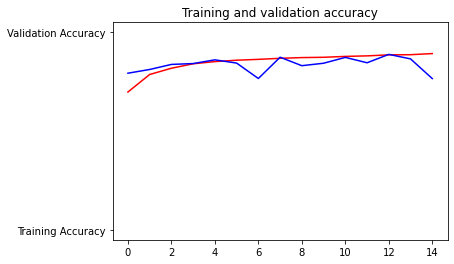

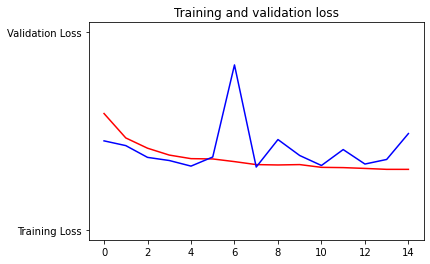

In [10]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recupera uma lista de resultados da lista de conjuntos
# de dados de treinamento e teste para cada época de treinamento
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Obter número de épocas

#------------------------------------------------
# Plotagem da precisão do treino e validação por época
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plotando a perda no treinamento e validação por época
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Saída desejada. Gráficos com métricas de treinamento e validação.

### Executando o modelo

Agora vamos dar uma olhada na execução de uma predição usando o modelo. Este código permitirá que você escolha 1 ou mais arquivos do seu sistema de arquivos, ele os carregará e os executará no modelo, indicando se o objeto é um cachorro ou um gato.

In [14]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving gato5.jpg to gato5.jpg
[4.660311e-10]
gato5.jpg is a cat
